# Task 1
# Kalman filter
## Case 2
![](Task1_desc.png)

### 1. See the data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv("case2.txt", header=None, names=['Time', "Roll angle"])
data.head()

,Time,Roll angle
0,0.000,14413
1,0.004,14388
2,0.008,14367
3,0.012,14397
4,0.016,14401


Let's plot it

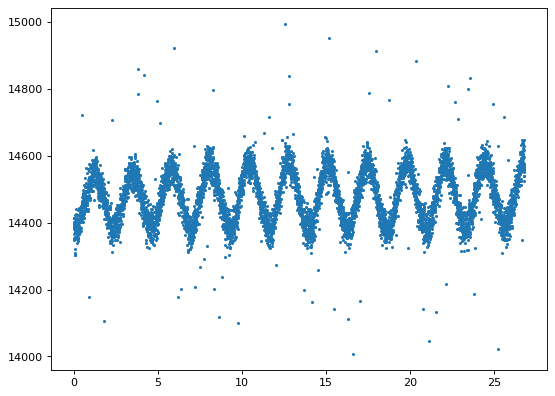

In [2]:
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(data["Time"], data["Roll angle"], s = 3);

### 2. Kalman filter theory

![](Kalman_theory.png)

In our case we don't know about controlling function `uk`, so we put all unknown information from the physical model to the error of the model: `x_k+1=xk+ξk`

### 2. Variable initialization 

In [3]:
err_sensor = np.var(data["Roll angle"]) # dispersion of sensor data
err_model = 400 #Assumption; dispersion of model error
err = err_sensor #Total error
angle_opt = data.iloc[0]["Roll angle"] # Init number of optimal roll angle

### 3. Kalman filter 

In [4]:
kalman_angles = []
for ind, row in data.iterrows():
    err = err_sensor*(err+err_model)/(err + err_sensor + err_model)
    K = err/err_sensor
    angle_opt = K*row["Roll angle"] + (1 - K) * angle_opt
    kalman_angles.append(angle_opt)

### 4. Plot results

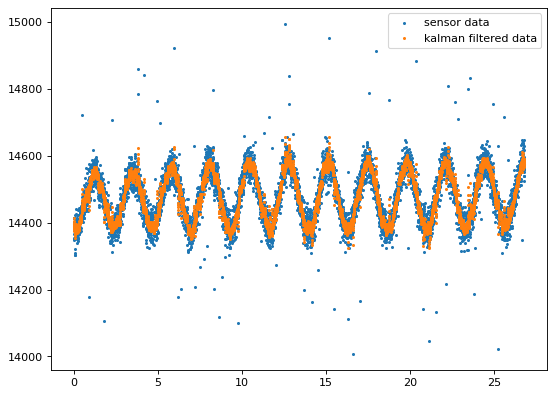

In [5]:
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(data["Time"], data["Roll angle"], s=3, label="sensor data");
plt.scatter(data["Time"], kalman_angles, s=3, label="kalman filtered data");
plt.legend();

# Task 2
# Camera calibration
![](Task2_desc.png)

We should find intrinsic and extrinsic camera parameters.
![](cam_params.png)

#### Image examples

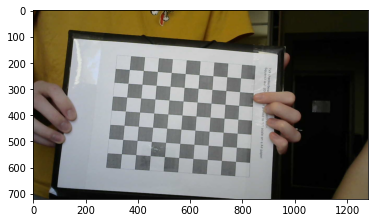

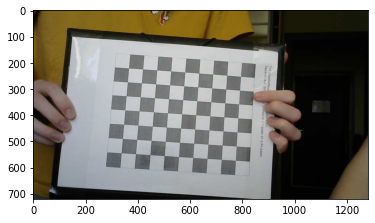

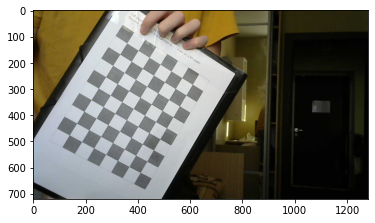

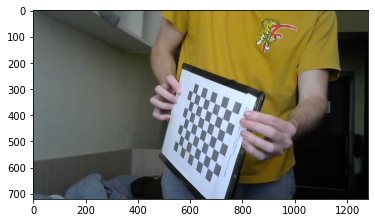

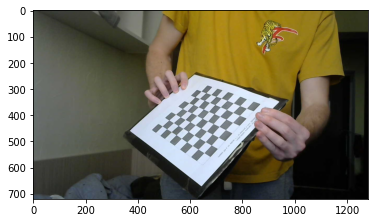

In [6]:
import glob
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

images = glob.glob('photos/*.jpg')
for ind, filename in enumerate(images):
    if ind==5:
        break
    img = cv.imread(filename)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()

#### Camera calibration

In [7]:
# This part of code was taken from OpenCV tutorial:
# https://docs.opencv.org/3.4.15/dc/dbb/tutorial_py_calibration.html
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx, ny = 9, 7
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:ny,0:nx].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('photos/*.jpg')

for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (ny,nx), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)

In [8]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

#### Intrinsic params

In [9]:
mtx

array([[1.38129503e+03, 0.00000000e+00, 6.14593225e+02],
       [0.00000000e+00, 1.36906077e+03, 3.15911268e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

#### Extrinsic params

Each image has own extrinsic params. So, for example, for first image rotation matrix is 

In [10]:
cv.Rodrigues(rvecs[0])[0]

array([[ 0.07200556,  0.99726615, -0.01659612],
       [-0.99089785,  0.07342342,  0.1128293 ],
       [ 0.11373938,  0.00832072,  0.99347578]])

Transpose vector for first image:

In [11]:
tvecs[0]

array([[-5.01792963],
       [ 4.29046598],
       [25.2451105 ]])

### Measure the object size

In a left size of image we have a phone, which size should be measured.  
We know, that the one side of square in chessboard is equal to 2 centimeter.  
We suppose that the phone and chessboard are on the same plane.

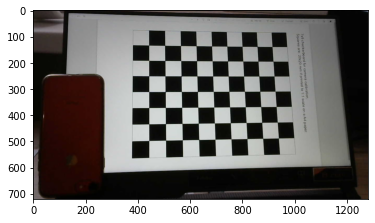

In [12]:
img = cv.imread("object.jpg")

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()

#### Find phone mask on the image

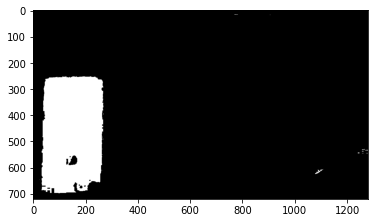

In [13]:
img1 = cv.inRange(img, np.array([0, 0, 25]), np.array([20, 20, 255]))

kernel = np.ones((3, 3))/2
img1 = cv.erode(img1, kernel, iterations = 1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.show()

#### Get the right contour

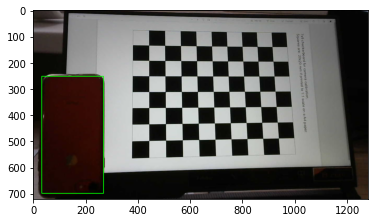

Phone width in pixels: 236
Phone height in pixels: 446


In [14]:
contours,hierarchy = cv.findContours(img1, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

img_copy = img.copy()
# loop over the contours individually
for c in contours:
    if cv.contourArea(c) < 200:
        continue
    x,y, phone_width_px, phone_height_px = cv.boundingRect(c)
    cv.rectangle(img_copy,(x,y),(x + phone_width_px, y + phone_height_px),(0,255,0),2)

plt.imshow(cv.cvtColor(img_copy, cv.COLOR_BGR2RGB))
plt.show()
print(f"Phone width in pixels: {phone_width_px}")
print(f"Phone height in pixels: {phone_height_px}")

#### Estimate the size of phone

In [15]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
nx, ny = 9, 7

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
ret, corners = cv.findChessboardCorners(gray, (ny,nx), None)

chess_square_side_px = np.sqrt(((corners[0][0]-corners[1][0])**2).sum())
chess_square_side_cm = 2

print(f"Phone width in centimeters: {chess_square_side_cm/chess_square_side_px * phone_width_px}")
print(f"Phone height in centimeters: {chess_square_side_cm/chess_square_side_px * phone_height_px}")

Phone width in centimeters: 7.498117804204491
Phone height in centimeters: 14.170171782522047
